# Retail Data Analytics
<br>
This notebook contains the code for training and deploying a retail data analytics model. The goal is to estimate the weekly sales of a store given the input features.
<br>
The data is stored in csv files. There is one csv file containing the training data (train.csv) and one containing the test data (test.csv). Additionally, one can find all feature names in a csv file calls "features_list.csv". 

In [40]:
import pandas as pd
import boto3
import sagemaker

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [41]:
# set number of samples that shall be used for visualising test true data and predicted data
NUM_SAMPLES_TEST_VISUALIZATION = 100

## Load Data to S3

In [42]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

region = boto3.Session().region_name

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [43]:
import os
# folder containing the training and test data
data_dir = "data_converted"

# set prefix, a descriptive name for a directory  
prefix = "retail_analytics_data"

# upload all data to S3
train_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "train.csv"), bucket=bucket, key_prefix=prefix)
val_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "val.csv"), bucket=bucket, key_prefix=prefix)
test_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "test.csv"), bucket=bucket, key_prefix=prefix)

### Test 
Check if uploading the data to S3 was successfull.

In [44]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

retail_analytics_data/test.csv
retail_analytics_data/train.csv
retail_analytics_data/val.csv
Test passed!


## Train the Benchmark Model

<br>
As benchmark model a linear regression model should be trained. The model is trained using the sklearn library. The training code is located in the file "train_linear_regression.py" within the source folder.

In [45]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'source/train_linear_regression.py'

sklearn_linear_regression = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session)

### Train

In [46]:
%%time

# Train the estimator on S3 training data
sklearn_linear_regression.fit({"train": train_input, "validation": val_input})

2021-01-05 16:26:06 Starting - Starting the training job...
2021-01-05 16:26:30 Starting - Launching requested ML instancesProfilerReport-1609863966: InProgress
.........
2021-01-05 16:27:51 Starting - Preparing the instances for training......
2021-01-05 16:29:07 Downloading - Downloading input data
2021-01-05 16:29:07 Training - Downloading the training image...
2021-01-05 16:29:33 Uploading - Uploading generated training model2021-01-05 16:29:23,047 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2021-01-05 16:29:23,049 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-05 16:29:23,067 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-01-05 16:29:23,497 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-05 16:29:23,512 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-05 16:29:23,525 sagem

### Deploy

In [ ]:
%%time

# deploy the model to create a predictor
predictor_linear_regression = sklearn_linear_regression.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

### Evaluate

In [14]:
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)

# labels are in the first column
test_y_true = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

In [ ]:
# compute MSE
from sklearn.metrics import mean_squared_error

test_y_preds = predictor_linear_regression.predict(test_x.values)
rmse = mean_squared_error(test_y_true, test_y_preds, squared=False)
print(f"RMSE: {rmse}")

In [ ]:
# plot some results
num_samples_test = 100
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Train Linear Regression with Standardization

In [ ]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'source/train_linear_regression.py'

sklearn_linear_regression_standardized = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session
    hyperparameters = {"standardize": True})

### Train

In [ ]:
%%time

# Train the estimator on S3 training data
sklearn_linear_regression_standardized.fit({"train": train_input, "validation": val_input})

### Deploy

In [ ]:
%%time

# deploy the model to create a predictor
predictor_linear_regression_standardized = 
                        sklearn_linear_regression_standardized.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

### Evaluate

In [ ]:
# compute MSE
from sklearn.metrics import mean_squared_error

test_y_preds = predictor_linear_regression_standardized.predict(test_x.values)
rmse = mean_squared_error(test_y_true, test_y_preds, squared=False)
print(f"RMSE: {rmse}")

In [ ]:
# plot some results
num_samples_test = 100
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Train Decision Tree Regressor

In [10]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'train_decision_tree.py'

hyperparameters = {
    "n-iter": 7,
    "n-folds": 5
}

sklearn_decision_tree = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    source_dir = "source",
    hyperparameters = hyperparameters)

### Train

In [11]:
%%time

# Train the estimator on S3 training data
sklearn_decision_tree.fit({"train": train_input, "validation": val_input})

2021-01-05 12:39:29 Starting - Starting the training job...
2021-01-05 12:39:53 Starting - Launching requested ML instancesProfilerReport-1609850369: InProgress
.........
2021-01-05 12:41:14 Starting - Preparing the instances for training......
2021-01-05 12:42:15 Downloading - Downloading input data...
2021-01-05 12:42:59 Training - Training image download completed. Training in progress..2021-01-05 12:42:59,759 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2021-01-05 12:42:59,761 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-05 12:42:59,770 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-01-05 12:43:03,232 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44619 sha256=b886a61de4ca4835b994b4

### Deploy

In [12]:
%%time

# deploy the model to create a predictor
predictor_decision_tree = sklearn_decision_tree.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------------!CPU times: user 290 ms, sys: 43.8 ms, total: 334 ms
Wall time: 8min 32s


### Evaluate

In [22]:
# compute MSE
from sklearn.metrics import mean_squared_error

test_y_preds = predictor_decision_tree.predict(test_x.values)
rmse = mean_squared_error(test_y_true, test_y_preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 6069.75347550491


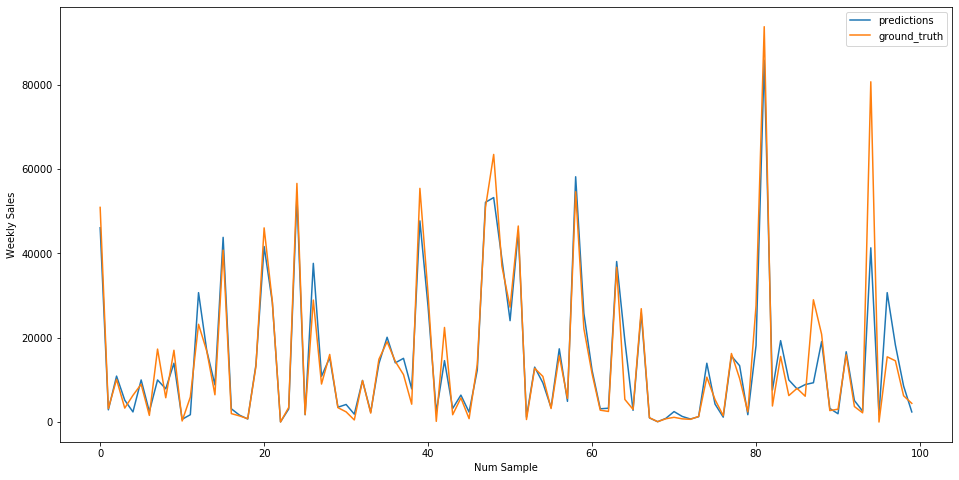

In [23]:
# plot some results
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Train Random Forest Regressor

In [24]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'train_random_forest.py'

hyperparameters = {
    "n-iter": 20,
    "n-folds": 5
}

sklearn_random_forest = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    source_dir = "source",
    hyperparameters = hyperparameters)

### Train

In [ ]:
%%time

# Train the estimator on S3 training data
sklearn_random_forest.fit({"train": train_input, "validation": val_input})

2021-01-05 13:12:47 Starting - Starting the training job...
2021-01-05 13:13:11 Starting - Launching requested ML instancesProfilerReport-1609852366: InProgress
.........
2021-01-05 13:14:32 Starting - Preparing the instances for training......
2021-01-05 13:15:44 Downloading - Downloading input data
2021-01-05 13:15:44 Training - Downloading the training image...
2021-01-05 13:16:13 Training - Training image download completed. Training in progress.2021-01-05 13:16:05,157 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2021-01-05 13:16:05,159 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-05 13:16:05,169 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-01-05 13:16:05,519 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp

### Deploy

In [ ]:
%%time

# deploy the model to create a predictor
predictor_random_forest = sklearn_random_forest.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

### Evaluate

In [ ]:
# compute MSE
from sklearn.metrics import mean_squared_error

test_y_preds = predictor_random_forest.predict(test_x.values)
rmse = mean_squared_error(test_y_true, test_y_preds, squared=False)
print(f"RMSE: {rmse}")

In [ ]:
# plot some results
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Train XGBoost Regressor

In [15]:
container = sagemaker.image_uris.retrieve('xgboost', region=region, version="1.0-1")

prefix = "retail_data_analytics"

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)

In [23]:
# let's use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')
}


In [37]:
tuner_log = HyperparameterTuner(xgb,
                                objective_metric_name="validation:rmse",
                                objective_type='Minimize',
                                hyperparameter_ranges=hyperparameter_ranges,
                                max_jobs=20,
                                max_parallel_jobs=2,
                                strategy='Bayesian')

### Train

In [38]:
## Starts the hyperparameter tuning job
tuner_log.fit({"train": train_input, "validation": val_input}, include_cls_metadata=False)

..............................................................................................................

KeyboardInterrupt: 

### Deploy

In [ ]:
# get best estimator
xgboost_model = tuner_log.best_estimator()

In [ ]:
%%time

# deploy the model to create a predictor
predictor_xgboost = xgboost_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

### Evaluate

## Clean Up Resources

In [ ]:
predictor_linear_regression.delete_endpoint()

In [ ]:
predictor_linear_regression_standardized.delete_endpoint()

In [ ]:
predictor_decision_tree.delete_endpoint()

In [ ]:
predictor_random_forest.delete_endpoint()

In [ ]:
predictor_xgboost.delete_endpoint()

In [39]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '1K4M8QDP3S1ZFW2J',
   'HostId': 'WKATjjHWRBQLQVWKy5kVTTa4KXMT8ySC6wpvdvrnAElJbgU566dl68Rj6wblikIul/8ebd4TGgQ=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'WKATjjHWRBQLQVWKy5kVTTa4KXMT8ySC6wpvdvrnAElJbgU566dl68Rj6wblikIul/8ebd4TGgQ=',
    'x-amz-request-id': '1K4M8QDP3S1ZFW2J',
    'date': 'Tue, 05 Jan 2021 16:25:18 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker-scikit-learn-2021-01-05-13-12-46-654/rule-output/ProfilerReport-1609852366/profiler-output/profiler-reports/LowGPUUtilization.json'},
   {'Key': 'sagemaker-scikit-learn-2021-01-05-12-39-29-619/profiler-output/framework/training_job_end.ts'},
   {'Key': 'sagemaker-scikit-learn-2021-01-05-12-35-04-065/profiler-output/system/incremental/2021010512/1609850400.algo-1.json'},
   {'Key': 'sagemaker-scikit-learn-2021-01-05-13-12-46-654/profi